# RED NEURONAL.

El armado de esta red neuronal pretende predecir la siguiente nota.

La base de datos elegida es un conjunto de datos que contiene alrededor de 200hs de grabaciones de audio y MIDI emparejadas de diez años de Concurso Internacional de Piano.

FUENTE: https://magenta.tensorflow.org/datasets/maestro

In [ ]:
# import zipfile as zf
# files = zf.ZipFile("/content/maestro-v3.0.0-midi.zip", 'r')
# files.extractall('data/')
# files.close()
!pip install pretty_midi
!pip install tensorflow
!pip install scikit-learn

Se instalan todos los paquetes relevantes para procesar y escuchar archivos MIDI, glob para iterar sobre los archivos del dataset, collections para el diccionario con valor por defecto, y pathlib para abrir el archivo.

In [ ]:
import collections
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import tensorflow as tf
from sklearn.model_selection import train_test_split

Se define un directorio que contendra todos los archivos MIDI que seran analizados. Se arma una funcion que convierte esos archivos a un DataFrame de pandas donde utilizamos una variable para definir una "nota" que contendra como caracteristica el tono (pitch). Tono es la calidad sonora de la nota, lo que la distingue de otras.

In [57]:
directorio = pathlib.Path('/content/ArchivosMIDI')
filenames = glob.glob(str(directorio/'*.mid*'))
print('num archivos:', len(filenames))

# sample_file = "/content/MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_07_Track07_wav.midi"
# print(sample_file)

def midi_a_notas(midifile: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midifile)
    instrumento = pm.instruments[0]
    notas = collections.defaultdict(list)

    notas_orden = sorted(instrumento.notes, key=lambda nota: nota.start)
    previa_inicio = notas_orden[0].start

    for nota in notas_orden:
        notas['pitch'].append(nota.pitch)

    return pd.DataFrame({nombre: np.array(valor) for nombre, valor in notas.items()})

num archivos: 105


Se agrega un fragmento de codigo hecho por otra persona, que permite escribir un dataframe con notas en un archivo midi y lo devuelve como prettyMIDI para poder escucharlo (No se usa):

In [58]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

Se procesan los archivos MIDI, se extraen las notas de cada archivo y se preparan los datos para el modelo del aprendizaje automatico mas adelante.

In [60]:
notasGlobal = []
tam_muestra = 10

for f in filenames[:tam_muestra]:
  notas = midi_a_notas(f)
  notasGlobal.append(notas)

notasGlobal = pd.concat(notasGlobal)
print(notasGlobal.head())

indice_notas = ['pitch']
notas_entrenamiento = np.array([notasGlobal[key] for key in indice_notas]).flatten()
np.set_printoptions(precision=3)
dataset_nota = tf.data.Dataset.from_tensor_slices(notas_entrenamiento)
print(notas_entrenamiento)
print(list(dataset_nota.as_numpy_iterator()))

   pitch
0     40
1     39
2     40
3     40
4     40
[40 39 40 ... 31 26 31]
[40, 39, 40, 40, 40, 40, 40, 39, 40, 40, 40, 39, 40, 40, 40, 46, 47, 40, 47, 40, 47, 40, 47, 40, 47, 40, 40, 47, 40, 46, 47, 40, 47, 40, 40, 46, 47, 47, 40, 47, 40, 47, 54, 53, 40, 47, 40, 54, 41, 54, 40, 47, 54, 47, 40, 54, 47, 40, 47, 54, 40, 47, 54, 53, 61, 40, 54, 47, 40, 61, 54, 47, 61, 40, 47, 61, 54, 40, 47, 54, 61, 40, 47, 54, 61, 40, 60, 54, 69, 61, 47, 40, 41, 61, 47, 69, 40, 54, 69, 61, 54, 47, 40, 61, 54, 69, 47, 40, 61, 54, 69, 40, 47, 41, 54, 61, 69, 40, 47, 54, 61, 47, 69, 40, 62, 53, 54, 40, 47, 69, 62, 54, 40, 62, 69, 47, 54, 40, 69, 62, 47, 54, 62, 40, 47, 54, 47, 69, 40, 62, 54, 40, 76, 47, 69, 64, 54, 47, 69, 62, 54, 40, 47, 54, 40, 47, 54, 62, 47, 54, 69, 47, 54, 40, 76, 69, 47, 54, 40, 47, 69, 62, 54, 47, 40, 54, 76, 40, 69, 41, 54, 47, 40, 41, 69, 54, 62, 47, 40, 64, 54, 40, 76, 69, 64, 54, 47, 40, 69, 54, 62, 47, 40, 69, 54, 47, 62, 40, 41, 54, 47, 54, 55, 62, 47, 40, 54, 62, 69, 47, 5

Luego, transformamos el dataset de las notas en ventanas de secuencias para su uso.

In [61]:
def ventanizar(dataset, tam_ventana, alfabeto_notas = 128,) -> tf.data.Dataset:
  tam_ventana = tam_ventana + 1

  windows = dataset.window(tam_ventana, shift=1, stride=1, drop_remainder=True)
  flatten = lambda x: x.batch(tam_ventana, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize tono de las notas
  def normalizar_tono(x):
    x = x/tam_ventana
    return x

  # Partimos los indices
  def partir_indices(sequences):
    inputs = sequences[:-1]
    outputs_dense = sequences[-1]
    return normalizar_tono(inputs), outputs_dense
  return sequences.map(partir_indices,num_parallel_calls=tf.data.AUTOTUNE)

ventanitas = ventanizar(dataset_nota, 100)
dataset_pandas = pd.DataFrame(list(ventanitas.as_numpy_iterator()), columns=['inputs','output'])
dataset_pandas.head()

,inputs,output
0,"[0.39603960396039606, 0.38613861386138615, 0.3...",54
1,"[0.38613861386138615, 0.39603960396039606, 0.3...",47
2,"[0.39603960396039606, 0.39603960396039606, 0.3...",40
3,"[0.39603960396039606, 0.39603960396039606, 0.3...",61
4,"[0.39603960396039606, 0.39603960396039606, 0.3...",54


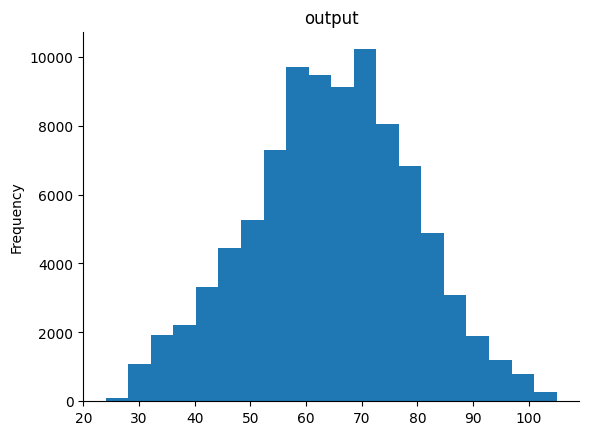

In [62]:
# @title output

from matplotlib import pyplot as plt
dataset_pandas['output'].plot(kind='hist', bins=20, title='output')
plt.gca().spines[['top', 'right',]].set_visible(False)

Preparacion de los datos para trabajar con la red

In [63]:
# neuronas_entrada = 100 / neuronas_de_la_capa_oculta = 60 / neurona_salida = 1

# Extraemos los datos de entrada y de salida
inputs = np.array(dataset_pandas['inputs'].tolist())
print(inputs.shape)
output = np.array(dataset_pandas['output'])
print(output.shape)
np.random.seed(100)

# Separar un conjunto de datos para entrenar y otro para probar
x_train, x_test, y_train, y_test = train_test_split(inputs, output, test_size=1/3)
print("x_train:\n", x_train)
print("x_test:\n", x_test)
print("y_train:\n", y_train)
print("y_test:\n", y_test)

(91138, 100)
(91138,)
x_train:
 [[0.436 0.406 0.465 ... 0.663 0.762 0.584]
 [0.485 0.366 0.802 ... 0.574 0.842 0.762]
 [0.545 0.574 0.812 ... 0.802 0.782 0.762]
 ...
 [0.495 0.762 0.644 ... 0.644 0.614 0.545]
 [0.713 0.832 0.812 ... 0.762 0.812 0.455]
 [0.644 0.663 0.624 ... 0.545 0.594 0.505]]
x_test:
 [[0.832 0.733 0.644 ... 0.673 0.653 0.634]
 [0.584 0.663 0.495 ... 0.594 0.545 0.733]
 [0.495 0.376 0.505 ... 0.624 0.564 0.396]
 ...
 [0.693 0.812 0.693 ... 0.624 0.693 0.604]
 [0.426 0.733 0.525 ... 0.653 0.495 0.614]
 [0.723 0.545 0.624 ... 0.495 0.376 0.495]]
y_train:
 [55 57 58 ... 63 70 50]
y_test:
 [59 77 66 ... 69 57 38]


Inicializacion de las variables y funciones para la red

In [64]:
# Pesos y sesgos
w_hidden = np.random.rand(60, 100) * 2 - 1
w_output = np.random.rand(1, 60) * 2 - 1
b_hidden = np.random.rand(60, 1) * 2 - 1
b_output = np.random.rand(1, 1) * 2 - 1

# Funcion de activacion y la derivada
relu = lambda x: np.maximum(x, 0)
logistic = lambda x: 1 / (1 + np.exp(-x))
d_relu = lambda x: np.where(x > 0, x, x * 0.01)
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

# Forward Propagation, recorrer la red hacia adelante
def forward_prop(x):
	z1 = w_hidden @ x + b_hidden
	a1 = relu(z1)
	z2 = w_output @ a1 + b_output
	a2 = logistic(z2)
	return z1, a1, z2, a2

# Backpropagation, recorrer la red hacia atras
def backward_prop(z1, a1, z2, a2, x, y):
	dc_da2 = 2 * a2 - 2 * y
	da2_dz2 = d_logistic(z2)
	dz2_da1 = w_output
	dz2_dw2 = a1
	dz2_db2 = 1
	da1_dz1 = d_relu(z1)
	dz1_dw1 = x
	dz1_db1 = 1

	dc_dw2 = dc_da2 @ da2_dz2 @ dz2_dw2.T
	dc_db2 = dc_da2 @ da2_dz2 * dz2_db2
	dc_da1 = dc_da2 @ da2_dz2 @ dz2_da1
	dc_dw1 = dc_da1 @ da1_dz1 @ dz1_dw1.T
	dc_db1 = dc_da1 @ da1_dz1 * dz1_db1

	return dc_dw1, dc_db1, dc_dw2, dc_db2

Entrenamiento de la red usando las funciones y los datos ya separados

In [ ]:
L = 0.05
epoch = 10_000

# Ejecutar descenso de gradiente
for i in range(epoch):
  # Seleccion aleatoria de unos de los datos de entrenamiento
  idx = np.random.choice(range(len(x_train)), 1, replace=False)
  x_sample = x_train[idx].T
  y_sample = y_train[idx]

  # Pasar los datos seleccionados a traves de la red
  z1, a1, z2, a2 = forward_prop(x_sample)
  # Distribuir el error a traves de la retro propagacion, devolver pendientes para pesos y sesgo
  dw_hidden, db_hidden, dw_output, db_output = backward_prop(z1, a1, z2, a2, x_sample, y_sample)
  # Actualizar pesos y sesgos
  w_hidden -= L * dw_hidden
  b_hidden -= L * db_hidden
  w_output -= L * dw_output
  b_output -= L * db_output
  # if(i % 10000 == 0):
print(w_hidden, b_hidden, w_output, b_output, sep="\n")
print("\n\n")